# The simple model 9
Теперь без Behler-Parrinello, но с графовой нейронной сетью от Megnet

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline

!pip install matminer
!pip install pymatgen
!pip install maml
!git clone https://github.com/bvd757/3DSC.git
!pip install megnet

from megnet.models import MEGNetModel
from megnet.data.crystal import CrystalGraph

from pymatgen.core.structure import Structure
from maml.describers import BPSymmetryFunctions

!pip install monty
from monty.json import MontyDecoder
from monty.serialization import loadfn

from megnet.data.crystal import CrystalGraph
from megnet.data.graph import GaussianDistance
from megnet.models import MEGNetModel

In [2]:
data = pd.read_csv('https://raw.githubusercontent.com/aimat-lab/3DSC/main/superconductors_3D/data/final/MP/3DSC_MP.csv', header = 1)
data1 = data.loc[data['tc'] > 0.0]
data1 = data1.loc[data['tc'] < 30.0]
data_t = data1[['tc']]
data2 = data1[['formula_sc']]

In [ ]:
from matminer.featurizers.composition import ElementProperty
from matminer.featurizers.conversions import StrToComposition
ep_feat = ElementProperty.from_preset(preset_name="magpie")
d = {"element": np.array(data2)[:, 0]}
df = pd.DataFrame(d)

df = StrToComposition().featurize_dataframe(df, "element")
df = ep_feat.featurize_dataframe(df, col_id = 'composition')

In [ ]:
structures1 = [0] * len(df)
targets1 = [0] * len(df)
data_t1 = np.array(data_t)
l = len(df)
for i in enumerate(os.listdir(path="/content/3DSC/superconductors_3D/data/final/MP/cifs")):
    if i[0] % 100 == 0: print(i[0])
    #print("\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n", i[1], "\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n")
    if i[1][:i[1].find('-MP')] not in df['element'].to_list(): continue
    j = df.loc[df['element'] == i[1][:i[1].find('-MP')]].index
    j = j[0]
    cif = Structure.from_file("/content/3DSC/superconductors_3D/data/final/MP/cifs/" + i[1])
    structures1[j] = cif
    targets1[j] = data_t1[j]

df1 = df[['MagpieData mean AtomicWeight', 'MagpieData mean MeltingT',
'MagpieData mean Electronegativity', 'MagpieData mean NdValence', 'MagpieData mean GSvolume_pa', 'MagpieData mean SpaceGroupNumber', 'MagpieData mean NdUnfilled']]

In [5]:
model = MEGNetModel(10, 2, nblocks=1, lr=1e-2,
                    n1=4, n2=4, n3=4, npass=1, ntarget=1,
                    graph_converter=CrystalGraph(bond_converter=GaussianDistance(np.linspace(0, 5, 10), 0.5)))

/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [ ]:
structure_for_test = Structure.from_file("/content/3DSC/superconductors_3D/data/final/MP/cifs/" + 'Ag0.55Hg0.45-MP-mp-770433.cif')
A = []
B = []
for i in range(len(structures1)):
    if i % 100 == 0:
        print('\n\n\n\n\n\n', i, len(B) / (i + 1), '\n\n\n\n\n\n')
        
    if structures1[i] == 0:
        B.append(i)
        continue

    try:
        model.train([structure_for_test, structures1[i]], [1, 1], epochs=1);
        A.append(i)
    except:
        B.append(i)

B = sorted(B, reverse = True)

In [7]:
structures2 = structures1.copy()
targets2 = targets1.copy()
df2 = df1.copy()
df2.drop(labels=B, axis=0, inplace=True)

for i in B:
    structures2.pop(i)
    targets2.pop(i)

In [8]:
len(A)

1166

In [ ]:
X_train, y_train = structures2, targets2
model.train([structures2[9], structures2[0]], [1, 1], epochs=10)

In [ ]:
predictions_g = np.zeros(len(X_train))
for i in range(len(X_train)):
    if i % 50 == 0: print(i)
    predictions_g[i] = model.predict_structure(X_train[i]).ravel()
df2['graph'] = predictions_g

In [11]:
df2

,MagpieData mean AtomicWeight,MagpieData mean MeltingT,MagpieData mean Electronegativity,MagpieData mean NdValence,MagpieData mean GSvolume_pa,MagpieData mean SpaceGroupNumber,MagpieData mean NdUnfilled,graph
8,77.796450,1382.655000,1.568333,1.666667,34.138333,227.333333,0.000000,0.999839
9,190.406740,1859.163333,1.555000,4.666667,26.703333,225.000000,5.333333,0.999543
24,43.163400,1976.976667,2.003333,3.333333,10.225000,185.666667,0.000000,0.999195
25,112.501400,698.143333,1.830000,10.000000,21.616667,167.666667,0.000000,1.000557
26,123.386835,1213.965000,1.515000,5.500000,26.613750,209.500000,4.500000,0.998361
...,...,...,...,...,...,...,...,...
3387,152.968000,3172.666667,2.016667,3.333333,18.431667,217.333333,6.666667,0.996204
3388,141.879850,2784.950000,2.630000,3.000000,14.313750,174.750000,4.500000,0.995013
3389,65.380000,692.680000,1.650000,10.000000,13.960000,194.000000,0.000000,0.997695
3390,73.994667,1171.120000,1.543333,7.333333,17.038333,194.000000,2.666667,0.997821


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df2, pd.DataFrame(targets2), test_size=0.2, random_state=85)

param_grid_rfr = { 
            "n_estimators"      : [30, 100, 300],
            "max_features"      : ["auto", "sqrt", "log2"],
            "min_samples_split" : [2,4,8],
            "bootstrap": [True, False],
            }
rfr = RandomForestRegressor()
CV_rfr = GridSearchCV(estimator = rfr, param_grid = param_grid_rfr, cv = 7)
CV_rfr.fit(X_train, y_train.values.ravel())

In [ ]:
CV_rfr.best_params_

{'bootstrap': True,
 'max_features': 'log2',
 'min_samples_split': 2,
 'n_estimators': 30}

In [ ]:
rfr1 = RandomForestRegressor(max_features = 'log2', min_samples_split = 2, bootstrap = True, n_estimators = 30)
rfr1.fit(X_train, y_train.values.ravel())
predictions = rfr1.predict(X_test)
predictions1 = rfr1.predict(X_train)
score = cross_val_score(rfr1, X_test, y_test, scoring='neg_mean_squared_error', cv = 5)

93 samples were used to train the model
The average train accuracy is 0.90
The average test accuracy is -0.45

186 samples were used to train the model
The average train accuracy is 0.88
The average test accuracy is -0.29

279 samples were used to train the model
The average train accuracy is 0.89
The average test accuracy is -0.31

372 samples were used to train the model
The average train accuracy is 0.88
The average test accuracy is -0.31

466 samples were used to train the model
The average train accuracy is 0.89
The average test accuracy is -0.15

559 samples were used to train the model
The average train accuracy is 0.89
The average test accuracy is -0.08

652 samples were used to train the model
The average train accuracy is 0.89
The average test accuracy is -0.10

745 samples were used to train the model
The average train accuracy is 0.88
The average test accuracy is -0.04

838 samples were used to train the model
The average train accuracy is 0.88
The average test accuracy is 

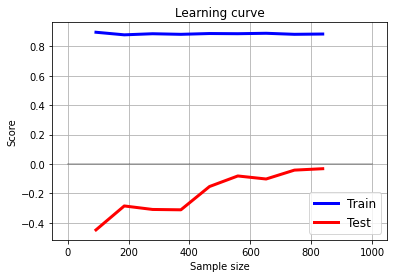

In [16]:
from sklearn.model_selection import learning_curve
train_size_abs, train_scores, test_scores = learning_curve(rfr1, df2, pd.DataFrame(targets2).values.ravel(),
                                                           train_sizes=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

for train_size, cv_train_scores, cv_test_scores in zip(train_size_abs, train_scores, test_scores):
    print(f"{train_size} samples were used to train the model")
    print(f"The average train accuracy is {cv_train_scores.mean():.2f}")
    print(f"The average test accuracy is {cv_test_scores.mean():.2f}")
    print()

fig, ax = plt.subplots()
ax.grid()

plt.plot([0, 1000], [0, 0], color = 'black', alpha = 0.3)
plt.plot(train_size_abs, train_scores.mean(axis = 1), color = 'blue', label=r'Train', linewidth = 3)
plt.plot(train_size_abs, test_scores.mean(axis = 1), color = 'red', label=r'Test', linewidth = 3)
ax.set_xlabel('Sample size')
ax.set_ylabel('Score')
plt.title("Learning curve")
plt.grid(True)
plt.legend(loc='best', fontsize=12)
plt.show()
#plt.ylim((0, 4))
plt.show()

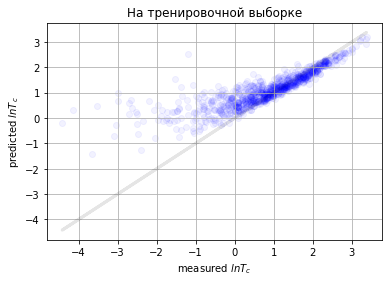

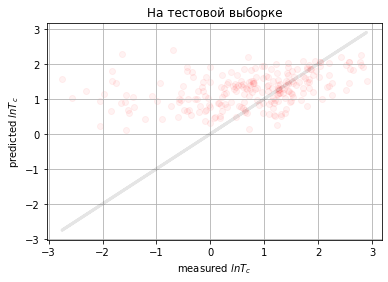

In [15]:
fig, ax = plt.subplots()
ax.grid()


plt.scatter(np.log(y_train), np.log(predictions1), color = 'blue', alpha = 0.05)
plt.plot(np.log(y_train), np.log(y_train), color = 'black', linewidth = 3, alpha = 0.1)
ax.set_xlabel('measured $ln T_c$')
ax.set_ylabel('predicted $ln T_c$')
plt.title("На тренировочной выборке")
#plt.ylim((0, 4))
plt.show()

plt.grid()
plt.scatter(np.log(y_test), np.log(predictions), color = 'red', alpha = 0.05)
plt.plot(np.log(y_test), np.log(y_test), color = 'black', linewidth = 3, alpha = 0.1)
plt.xlabel('measured $ln T_c$')
plt.ylabel('predicted $ln T_c$')
plt.title("На тестовой выборке")
#plt.ylim((0, 4))
plt.show()